# Imports and functions

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score



In [42]:
import torchvision
import engine
import engine_boosted
import engine_boosted_multi
import helper_functions

In [43]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from collections import deque  # Import deque for early stopping
import warnings

# Suppress the specific UserWarning related to y_pred and y_true class mismatch
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

In [44]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy using sklearn
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [45]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

In [46]:
kernel = {
    'ATF2': [10] ,
    'ATF3' : [10] ,
    'CEBPB' : [10] ,
    'CREB1' : [8] ,
    'CTCF' : [15] ,
    'E2F4' : [13] ,
    'EGR1' : [10] ,
    'EFL1' : [9] ,
    'ELK1' : [9] ,
    'FOS' : [8] ,
    'FOXA1' : [8] ,
    'GABPA' : [10] ,
    'JUN' : [14] ,
    'JUND' : [11] ,
    'MAFK' : [10] ,
    'MAX' : [6] ,
    'MAZ' : [8] ,
    'MXI1' : [6] ,
    'MYC' : [8] ,
    'NRF1' : [11] ,
    'RELA' : [10] ,
    'REST' : [20] ,
    'RFX5' : [14] ,
    'SP1' : [9] ,
    'SRF' : [16] ,
    'TCF7L2' : [9] ,
    'TCF12' : [7] ,
    'TEAD4' : [8] ,
    'USF1' : [10] ,
    'USF2' : [10] ,
    'YY1' : [12] ,
    'ZBTB33' : [10] ,
    'ZNF274' : [12]
}

In [47]:
tf_class = {
    'ATF2': 0,
    'ATF3': 1,
    'CEBPB': 2,
    'CREB1': 3,
    'CTCF': 4,
    'E2F4': 5,
    'EGR1': 6,
    'EFL1': 7,
    'ELK1': 8,
    'FOS': 9,
    'FOXA1': 10,
    'GABPA': 11,
    'JUN': 12,
    'JUND': 13,
    'MAFK': 14,
    'MAX': 15,
    'MAZ': 16,
    'MXI1': 17,
    'MYC': 18,
    'NRF1': 19,
    'RELA': 20,
    'REST': 21,
    'RFX5': 22,
    'SP1': 23,
    'SRF': 24,
    'TCF7L2': 25,
    'TCF12': 26,
    'TEAD4': 27,
    'USF1': 28,
    'USF2': 29,
    'YY1': 30,
    'ZBTB33': 31,
    'ZNF274': 32
}

# Set up device agnostic code

In [48]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [49]:
import pandas as pd

# Read the list of TFs from the file
tf_list_path = '/mnt/raid1/thalassini/home/Downloads/target_names_6.txt'
with open(tf_list_path, 'r') as file:
    tf_list = file.read().splitlines()

# Define the directory where the CSV files for each TF are located
base_directory = '/mnt/raid1/thalassini/home/filtered_fimo_chrom_200/'

# Combine data for each TF and write to a single CSV file
for tf in tf_list:
    file_path = f'{base_directory}{tf.upper()}/datasets/data.csv'
    
    try:
        df = pd.read_csv(file_path)
        
        # Add a column to identify the TF
        df['TF'] = tf
        
        # Append data to the master DataFrame or create it if it doesn't exist
        if 'master_df' in locals():
            master_df = pd.concat([master_df, df], ignore_index=True)
        else:
            master_df = df
    except FileNotFoundError:
        print(f"File not found for TF: {tf}")

# Save the combined DataFrame to a new CSV file
output_csv_path = '/mnt/raid1/thalassini/home/tf_data/combined_6_data.csv'
master_df.to_csv(output_csv_path, index=False)

print(f"Combined data saved to {output_csv_path}")


File not found for TF: RCOR1
Combined data saved to /mnt/raid1/thalassini/home/tf_data/combined_6_data.csv


In [50]:
master_df

,chrom,data,class,TF
0,chr1,CTCCTTTTTCCCCCTCTGCCACAACCTCTAAATACTGAGGGCCCCA...,1,0
1,chr1,TATAGCAATCTGAATCCTTGTGCTAAACTTAATTGTCGTTGTCGTC...,1,0
2,chr6,AAAACCAAAACAAGAAGTCGGTCTCCTCTTTTTATATAATAGTTTA...,1,0
3,chr4,TTAGGTCATGCACACTGAACTGAAACTGAGATGAATGACATCATCA...,1,0
4,chr11,GAACAGAGGCTCAGGCAGCTGAAGTAACGTGCCTAAGGTCACATGG...,1,0
...,...,...,...,...
2391227,chr5,TCATACAGGTGAGAAACCCTACAAATGTAATGAGTGTGAAAAAACC...,0,ZNF274
2391228,chr19,ATTACACTTTCAAGGTTTCTCTCCACTATGAAGTCTATGATGGTAT...,0,ZNF274
2391229,chr19,TTACATTTGTAAGGCTTCTCTCCAGTATGGATGACCTGATGGGTAG...,0,ZNF274
2391230,chr1,TTCATACTGGAGAGAAACCCTACAAATGCAAAGAATGTTGCAAAGC...,0,ZNF274


In [51]:
print("Unique values in 'TF' column before mapping:", master_df['TF'].unique())


Unique values in 'TF' column before mapping: [0 1 2 3 4 5 6 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 25 27
 28 29 30 31 32 'ATF2' 'ATF3' 'CEBPB' 'CREB1' 'CTCF' 'E2F4' 'EGR1' 'ELF1'
 'ELK1' 'FOS' 'FOXA1' 'GABPA' 'JUN' 'JUND' 'MAFK' 'MAX' 'MAZ' 'MXI1' 'MYC'
 'NRF1' 'RELA' 'REST' 'RFX5' 'SP1' 'SRF' 'TCF12' 'TCF7L2' 'TEAD4' 'USF1'
 'USF2' 'YY1' 'ZBTB33' 'ZNF274']


In [52]:

# Apply the mapping to the 'TF' column
master_df['TF'] = master_df['TF'].map(tf_class)

# Drop rows with NaN values in the 'TF' column
master_df = master_df.dropna(subset=['TF'])

# Convert the 'TF' column to integers
master_df['TF'] = master_df['TF'].astype(int)
master_df

/tmp/ipykernel_923796/3393081513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['TF'] = master_df['TF'].astype(int)


,chrom,data,class,TF
1187016,chr1,CTCCTTTTTCCCCCTCTGCCACAACCTCTAAATACTGAGGGCCCCA...,1,0
1187017,chr1,TATAGCAATCTGAATCCTTGTGCTAAACTTAATTGTCGTTGTCGTC...,1,0
1187018,chr6,AAAACCAAAACAAGAAGTCGGTCTCCTCTTTTTATATAATAGTTTA...,1,0
1187019,chr4,TTAGGTCATGCACACTGAACTGAAACTGAGATGAATGACATCATCA...,1,0
1187020,chr11,GAACAGAGGCTCAGGCAGCTGAAGTAACGTGCCTAAGGTCACATGG...,1,0
...,...,...,...,...
2391227,chr5,TCATACAGGTGAGAAACCCTACAAATGTAATGAGTGTGAAAAAACC...,0,32
2391228,chr19,ATTACACTTTCAAGGTTTCTCTCCACTATGAAGTCTATGATGGTAT...,0,32
2391229,chr19,TTACATTTGTAAGGCTTCTCTCCAGTATGGATGACCTGATGGGTAG...,0,32
2391230,chr1,TTCATACTGGAGAGAAACCCTACAAATGCAAAGAATGTTGCAAAGC...,0,32


# Sequence length inspection and normalization

Max length:200, Min length: 200


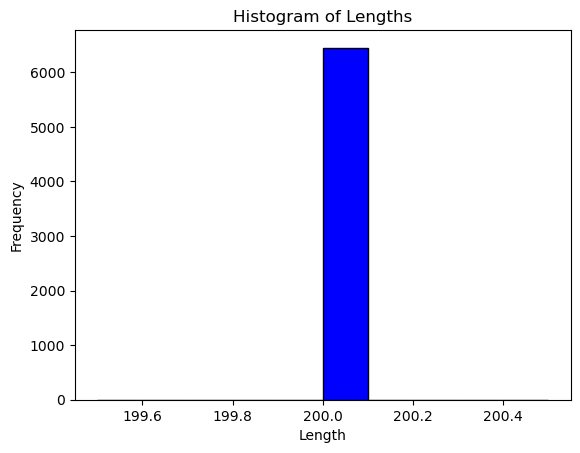

In [53]:
lengths= [len(item) for item in df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [54]:
# Find the maximum length of sequences
#min_length = min(len(seq) for seq in df['data'])
limit=200


# Pad or cut sequences to ensure they all have the same length
cut_sequences = [seq[:limit] for seq in df['data']]

# Update the DataFrame with the cut sequences
#df['data'] = cut_sequences

In [55]:
lengths= [len(item) for item in cut_sequences]
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')

Max length:200, Min length: 200


# Define X,y variables

In [56]:
X=[one_hot_encode(sequence) for sequence in cut_sequences]

In [57]:
X = torch.from_numpy(np.array(X)).type(torch.float)


In [58]:
X.shape

torch.Size([6450, 200, 4])

In [59]:
#y=np.array(df['TF'])
y=np.array(df['class'])

y[:3]

array([1, 1, 1])

In [60]:
y = torch.from_numpy(y).type(torch.float)

# Split the data in train, val and test set

In [61]:
train_loader, val_loader, test_loader = helper_functions.make_loaders(X,y)

# Create datasets and Dataloaders

In [62]:

batch_size=64
torch.manual_seed(42)

# Convert to PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Construct a 1 layer CNN with Maxpooling and Dropout

In [63]:
class Conv_v1(torch.nn.Module):

    def __init__(self):
        super(Conv_v1, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels= 30, kernel_size= 10)
        self.conv2 = torch.nn.Conv1d(in_channels= 30, out_channels= 60, kernel_size= 10)
        self.conv3 = torch.nn.Conv1d(in_channels= 60, out_channels= 360, kernel_size= 5)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size= 2)
        
        self.dropout = torch.nn.Dropout(p=0.25) 
        #in_features = 108 for 200kb, 588 for 1kb, 1188 for 2kb
        self.fc =  torch.nn.LazyLinear(out_features=2)
        #self.sigmoid = torch.nn.Sigmoid() will not be used since its intergraded in BCEWithLogitsLoss()
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        
        #print("Size after reshaping:", x.size())
        x=self.dropout(x)
        x = self.fc(x)
        #x = self.softmax(x)
        #x = self.sigmoid(x)
        return x


# Set up loss function and optimizer

In [64]:
from torch.optim import lr_scheduler
#weights = torch.tensor(weights).to(device)
#print(weights)

In [65]:
torch.manual_seed(42)

# Initialize model instance
model = Conv_v1()

#loss_fn = nn.BCEWithLogitsLoss(weight=weights)
loss_fn = nn.BCEWithLogitsLoss()

# Define oprimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define exponetntial lr with lr_scheduler
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

/mnt/raid1/thalassini/home/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [66]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.0311, -0.0296],
        [-0.0290, -0.0291],
        [-0.0058, -0.0026],
        [ 0.0042, -0.0088],
        [-0.0322,  0.0036]], grad_fn=<SliceBackward0>)

In [67]:
# Check number of classes in the model
num_classes_model = model.fc.out_features  # Adjust accordingly


In [68]:
num_classes_model

2

In [69]:
results, _ = engine_boosted.train_with_early_stopping(model=model,
                                                  train_dataloader=train_loader,
                                                  valid_dataloader=val_loader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=800,
                                                  device=device)


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6831 | train_bal_acc: 0.6169 | train_mcc: 0.2686 | train_auroc: 0.7186  |  valid_loss: 0.6602 | valid_bal_acc: 0.7671 | valid_mcc: 0.5488  |  valid_auroc: 0.8509
Epoch: 2 | train_loss: 0.6181 | train_bal_acc: 0.7506 | train_mcc: 0.5084 | train_auroc: 0.8272  |  valid_loss: 0.5394 | valid_bal_acc: 0.7876 | valid_mcc: 0.5638  |  valid_auroc: 0.8568
Epoch: 3 | train_loss: 0.5273 | train_bal_acc: 0.7550 | train_mcc: 0.5119 | train_auroc: 0.8321  |  valid_loss: 0.4800 | valid_bal_acc: 0.7867 | valid_mcc: 0.5772  |  valid_auroc: 0.8689
Epoch: 4 | train_loss: 0.4903 | train_bal_acc: 0.7715 | train_mcc: 0.5467 | train_auroc: 0.8501  |  valid_loss: 0.4457 | valid_bal_acc: 0.8018 | valid_mcc: 0.6089  |  valid_auroc: 0.8854
Epoch: 5 | train_loss: 0.4638 | train_bal_acc: 0.7880 | train_mcc: 0.5789 | train_auroc: 0.8691  |  valid_loss: 0.4325 | valid_bal_acc: 0.8011 | valid_mcc: 0.6085  |  valid_auroc: 0.8814
Epoch: 6 | train_loss: 0.4306 | train_bal_acc: 0.8097 | train_mcc

Epoch: 45 | train_loss: 0.0938 | train_bal_acc: 0.9742 | train_mcc: 0.9478 | train_auroc: 0.9967  |  valid_loss: 0.2021 | valid_bal_acc: 0.9285 | valid_mcc: 0.8607  |  valid_auroc: 0.9810
Epoch: 46 | train_loss: 0.0905 | train_bal_acc: 0.9762 | train_mcc: 0.9526 | train_auroc: 0.9972  |  valid_loss: 0.1739 | valid_bal_acc: 0.9372 | valid_mcc: 0.8748  |  valid_auroc: 0.9793
Epoch: 47 | train_loss: 0.0861 | train_bal_acc: 0.9752 | train_mcc: 0.9507 | train_auroc: 0.9975  |  valid_loss: 0.1788 | valid_bal_acc: 0.9286 | valid_mcc: 0.8624  |  valid_auroc: 0.9810
Epoch: 48 | train_loss: 0.0800 | train_bal_acc: 0.9780 | train_mcc: 0.9560 | train_auroc: 0.9976  |  valid_loss: 0.1784 | valid_bal_acc: 0.9273 | valid_mcc: 0.8547  |  valid_auroc: 0.9816
Epoch: 49 | train_loss: 0.0766 | train_bal_acc: 0.9784 | train_mcc: 0.9574 | train_auroc: 0.9981  |  valid_loss: 0.1743 | valid_bal_acc: 0.9326 | valid_mcc: 0.8647  |  valid_auroc: 0.9825
Epoch: 50 | train_loss: 0.0787 | train_bal_acc: 0.9802 | tra

Epoch: 89 | train_loss: 0.0122 | train_bal_acc: 0.9995 | train_mcc: 0.9990 | train_auroc: 1.0000  |  valid_loss: 0.1695 | valid_bal_acc: 0.9513 | valid_mcc: 0.9051  |  valid_auroc: 0.9798
Epoch: 90 | train_loss: 0.0118 | train_bal_acc: 0.9995 | train_mcc: 0.9990 | train_auroc: 1.0000  |  valid_loss: 0.1799 | valid_bal_acc: 0.9503 | valid_mcc: 0.8978  |  valid_auroc: 0.9863
Epoch: 91 | train_loss: 0.0116 | train_bal_acc: 0.9998 | train_mcc: 0.9995 | train_auroc: 1.0000  |  valid_loss: 0.1560 | valid_bal_acc: 0.9550 | valid_mcc: 0.9108  |  valid_auroc: 0.9878
Epoch: 92 | train_loss: 0.0117 | train_bal_acc: 1.0000 | train_mcc: 1.0000 | train_auroc: 1.0000  |  valid_loss: 0.1447 | valid_bal_acc: 0.9559 | valid_mcc: 0.9138  |  valid_auroc: 0.9871
Epoch: 93 | train_loss: 0.0105 | train_bal_acc: 0.9998 | train_mcc: 0.9995 | train_auroc: 1.0000  |  valid_loss: 0.1539 | valid_bal_acc: 0.9568 | valid_mcc: 0.9140  |  valid_auroc: 0.9887
Epoch: 94 | train_loss: 0.0100 | train_bal_acc: 0.9998 | tra

Epoch: 133 | train_loss: 0.0020 | train_bal_acc: 1.0000 | train_mcc: 1.0000 | train_auroc: 1.0000  |  valid_loss: 0.2045 | valid_bal_acc: 0.9516 | valid_mcc: 0.9038  |  valid_auroc: 0.9881
Epoch: 134 | train_loss: 0.0020 | train_bal_acc: 1.0000 | train_mcc: 1.0000 | train_auroc: 1.0000  |  valid_loss: 0.1862 | valid_bal_acc: 0.9577 | valid_mcc: 0.9151  |  valid_auroc: 0.9886
Epoch: 135 | train_loss: 0.0018 | train_bal_acc: 1.0000 | train_mcc: 1.0000 | train_auroc: 1.0000  |  valid_loss: 0.1867 | valid_bal_acc: 0.9548 | valid_mcc: 0.9034  |  valid_auroc: 0.9890
Epoch: 136 | train_loss: 0.0017 | train_bal_acc: 1.0000 | train_mcc: 1.0000 | train_auroc: 1.0000  |  valid_loss: 0.1970 | valid_bal_acc: 0.9552 | valid_mcc: 0.9105  |  valid_auroc: 0.9888
Early stopping after 136 epochs


In [70]:
range(len(results["train_loss"]))

range(0, 136)

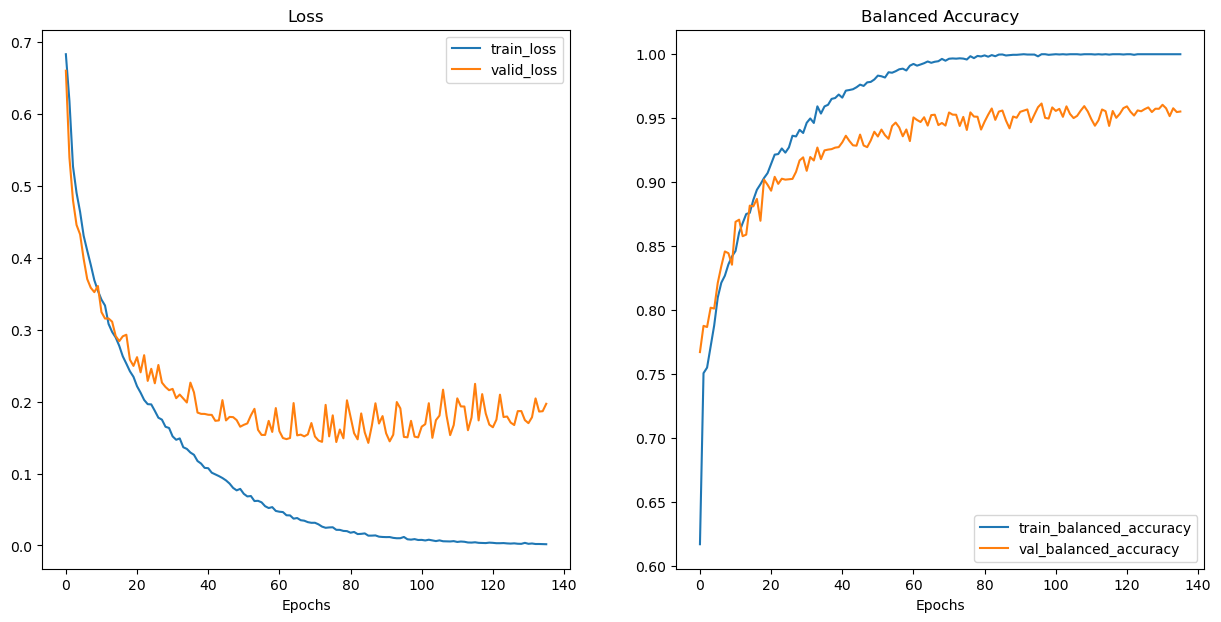

In [71]:
helper_functions.plot_loss_curves(results)
plt.savefig(f'All_TFs_CNN1_ADAM_BCEWithLogits_KERNEL=10_seq=200b.png')

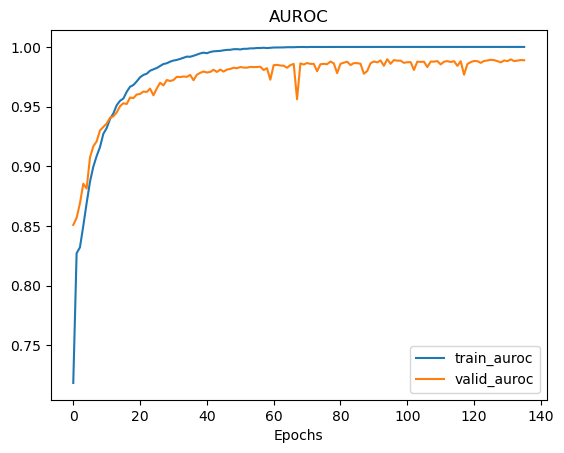

In [72]:
helper_functions.plot_auroc(results)

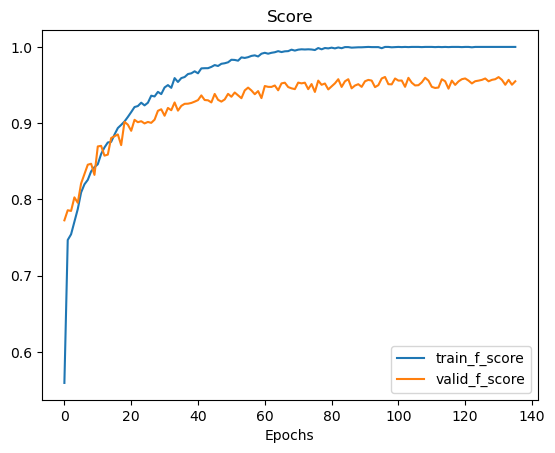

In [73]:
helper_functions.plot_f_score(results)

In [74]:
test_results = engine_boosted.test_step(model = model,
                                        dataloader = test_loader,
                                        loss_fn = loss_fn,
                                        device =device)

In [75]:
# Unpack the values
test_loss, test_bal_acc, test_mcc, test_f_score, test_auroc = test_results

print("Perfomance on held out test set")
print(f'Test loss: {float(test_loss)}  | Test bal acc {float(test_bal_acc)} |\
Test mcc {float(test_mcc)} | Test_f_score {float(test_f_score)} | Test auroc {float(test_auroc)}')   
    

Perfomance on held out test set
Test loss: 0.17220042929762885  | Test bal acc 0.9479610918061341 |Test mcc 0.8966781811003173 | Test_f_score 0.9478841136007992 | Test auroc 0.990617036819458
